In [1]:
# Install these libraries before continuing
library(tidyverse)
library(tidymodels)
#options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
# Reading data from web (stored in github repo)
cleveland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.cleveland.csv"
hungarian_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.hungarian.csv"
switzerland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.switzerland.csv"
beach_url <-  "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.va.csv"

names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thanl", "num")

cleveland <- read_csv(cleveland_url, col_names = names)
hungarian <- read_csv(hungarian_url, col_names = names)
switzerland <- read_csv(switzerland_url, col_names = names)
beach <- read_csv(beach_url, col_names = names)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thanl
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thanl
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thanl
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to r

In [3]:
# Changing all columns to doubles to be able to combine the 4 dataframes

cleveland <- mutate_all(cleveland, as.double)
hungarian <- mutate_all(hungarian, as.double)
switzerland <- mutate_all(switzerland, as.double)
beach <- mutate_all(beach, as.double)

heart_data_combined <- bind_rows(cleveland, hungarian, switzerland, beach)
heart_data_combined

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = .Primitive("as.double")(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Warning message:
“There were 9 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = .Primitive("as.double")(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see 

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
62,0,4,140,268,0,2,160,0,3.6,3,2,3,3
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
63,1,4,130,254,0,2,147,0,1.4,2,1,7,2


In [4]:
heart_data <- heart_data_combined |>
                mutate(num = ifelse(num %in% 1:4, 1, num)) |> # Correcting scaling of heart disease data (num)
                filter(chol != 0) |> # There is one incorrect point where chol = 0
                mutate(num = as_factor(num))

In [5]:
# Remove observations with NA values for predictor variables (age, chol, trestbps, thalach, oldpeak) only
heart_data <- heart_data |>
                filter(!is.na(age), !is.na(chol), !is.na(trestbps), !is.na(thalach), !is.na(oldpeak)) 

heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thanl,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
62,0,4,140,268,0,2,160,0,3.6,3,2,3,1
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
63,1,4,130,254,0,2,147,0,1.4,2,1,7,1


In [6]:
# Split data into training (80%) and testing (20%) data
set.seed(1234)

#
clean_heart <- heart_data |>
                    select(age, chol, trestbps, thalach, oldpeak, num)


heart_split <- initial_split(clean_heart, prop = 0.80, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train
heart_test

age,chol,trestbps,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,250,130,187,3.5,0
56,236,120,178,0.8,0
57,354,120,163,0.6,0
57,192,140,148,0.4,0
56,294,140,153,1.3,0
57,168,150,174,1.6,0
48,275,130,139,0.2,0
49,266,130,171,0.6,0
58,283,150,162,1.0,0


age,chol,trestbps,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,233,145,150,2.3,0
41,204,130,172,1.4,0
53,203,140,155,3.1,1
56,256,130,142,0.6,1
44,263,120,173,0.0,0
52,199,172,162,0.5,0
54,239,140,160,1.2,0
64,211,110,144,1.8,0
58,224,132,173,3.2,1


### Preliminary Analysis

In [7]:
### Preliminary Analysis Section Here ###

### KNN Classification

In [8]:
# Recipe (standardization)
set.seed(1234)
heart_recipe <- recipe(num ~ ., data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Define model specification - tune neighbors using 5-fold cross validation
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

vals <- tibble(neighbors = seq(from = 1, to = 100))

heart_vfold <- vfold_cv(heart_train, v = 5, strata = num)

# TODO: maybe revisit grid = 10 later and explore other k values
heart_accuracy <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(neighbors)

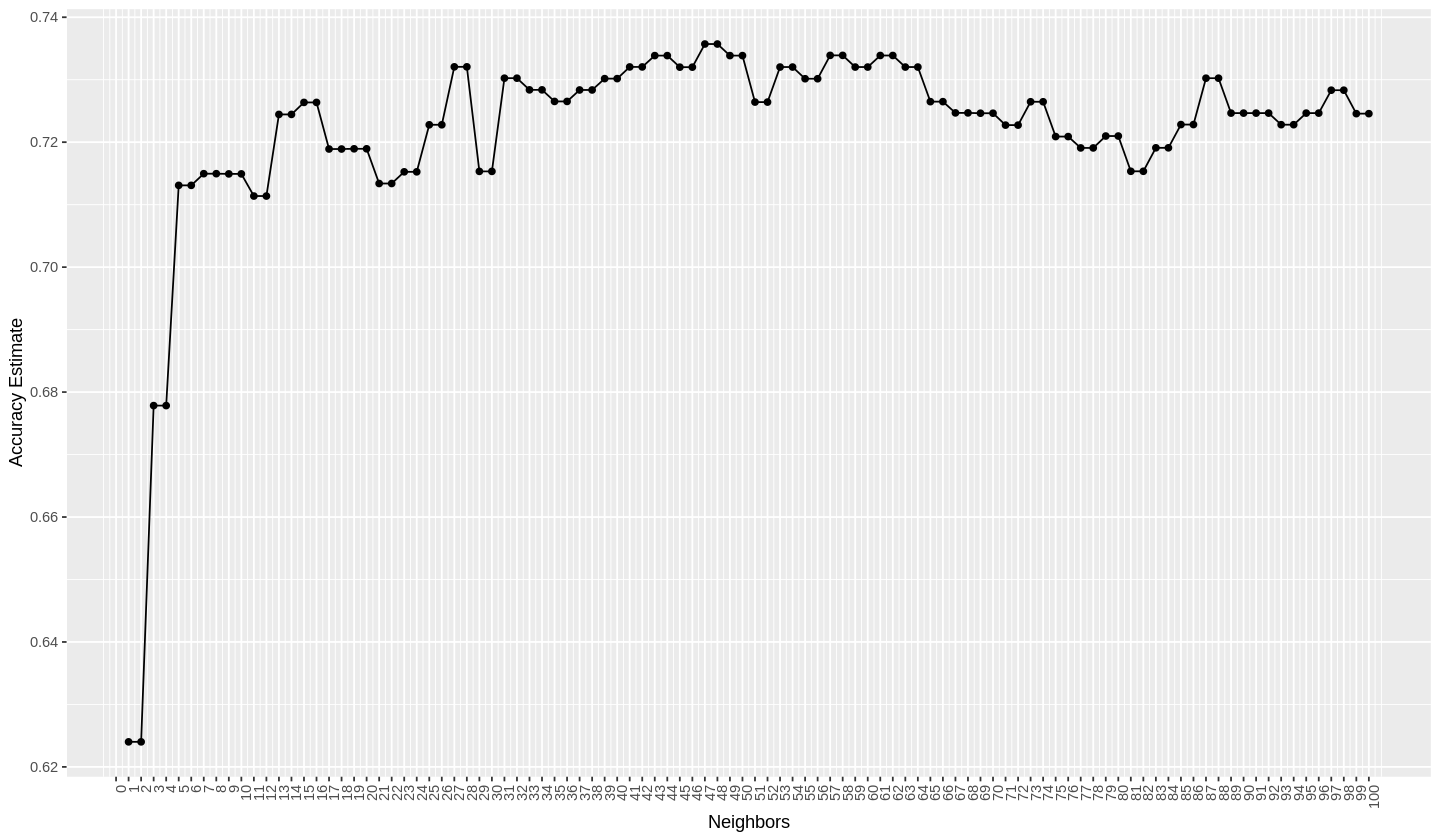

In [23]:
# Generate graph of accuracy
options(repr.plot.width = 12)
k_accuracies <- ggplot(heart_accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 100, by = 1)) +
       theme(axis.text.x = element_text(angle = 90, hjust = 1))

k_accuracies

In [24]:
# Determine best k

best_k <- heart_accuracy |>
            arrange(-mean) |>
            slice(1) |>
            select(neighbors) |>
            pull()

best_k

[1] 47

In [26]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_resample_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_train)